# Flux in Sunspot umbra 12/10/23-17/10/23

- load blos maps, mu maps, and generate hmi ic maps
- combine all arrays into one
- compute fluxes in the umbrae over the entire duration <br>
TODO
--
- can't use same x and y limits as region is moving across disc
- need to either adjust Ic threshold for umbrae, or normalise each map using local mean - and hope that constant value can be used

In [2]:
import _pickle as cPickle
import json
import sunpy
import sunpy.map
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

font = {'family' : 'Open Sans',
        'weight' : 'normal',
        'size'   : 15}

import matplotlib as mpl
mpl.rc_file_defaults()
plt.rc('font', **font)
mpl.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

import sunpy.visualization.colormaps as cm
magmap = mpl.colormaps['hmimag']

from datetime import datetime as dt
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d/%m %H:%M')

/scratch/slam/sinjan/.conda/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
hmisize=2.42407e-6*1.496e8*1e5

## Blos maps

In [5]:
dates = [12,13,14,15,16,17]

num_files = int(len(os.listdir('/scratch/slam/sinjan/arlongterm_hmi/blos_45/')))

In [6]:
hrt_arr = np.zeros((4102,4102,num_files))
hmi_arr = np.zeros((4102,4102,num_files))

In [4]:
num_files

129

In [41]:
start = 0

#hrt_tarr = np.zeros((4102,4102,num_files))

for i in dates:
    with open(f"/data/slam/sinjan/arlongterm_pickles/HRTs_remapped_on_HMI_202310{i}.pickle", "rb") as input_file:
        hrt_tmps = cPickle.load(input_file)
    
    with open(f"/data/slam/sinjan/arlongterm_pickles/HMIs_target_202310{i}.pickle", "rb") as input_file:
        hmi_tmps = cPickle.load(input_file)
        
    for i,smap in enumerate(hrt_tmps):
        #print(i, start+i)
        #print(smap.meta['date-obs'])
        hrt_arr[:,:,start+i] = smap.data
        #print()

    for i,smap in enumerate(hmi_tmps): #could zip together the two for loops, but need iterable
        nans=np.isnan(hrt_arr[:,:,start+i])
        tmp = smap.data
        tmp[nans] = np.nan
        hmi_arr[:,:,start+i] = tmp
        
    start += len(hrt_tmps)

In [52]:
with open('/data/slam/sinjan/arlongterm_pickles/hrt_arr_first_ar.pickle','wb') as f:
    cPickle.dump(hrt_arr,f)

In [129]:
with open('/data/slam/sinjan/arlongterm_pickles/hmi_arr_first_ar.pickle','wb') as f:
    cPickle.dump(hmi_arr,f)

In [53]:
hrt_arr.shape

(4102, 4102, 129)

In [7]:
with open('/data/slam/sinjan/arlongterm_pickles/hrt_arr_first_ar.pickle','rb') as f:
    hrt_arr=cPickle.load(f)

In [8]:
with open('/data/slam/sinjan/arlongterm_pickles/hmi_arr_first_ar.pickle','rb') as f:
    hmi_arr=cPickle.load(f)

## HMI Ic maps for selecting regions

- use hmi_ic_load.py on swan25, much faster

In [9]:
with open('/data/slam/sinjan/arlongterm_pickles/hmi_ic_cutout_20231012_20231017.pickle','rb') as f:
    hmi_ic_arr = cPickle.load(f)

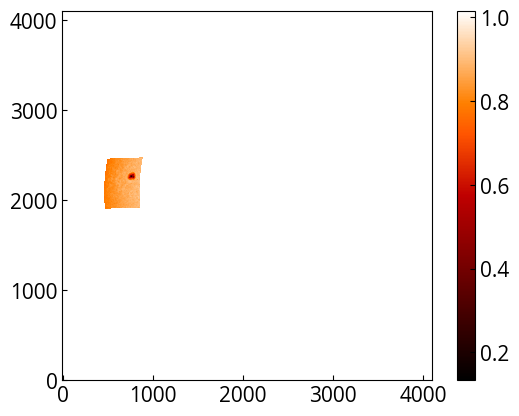

In [59]:
plt.imshow(hmi_ic_arr[...,47],origin="lower",cmap='gist_heat')
plt.colorbar()
plt.show()

## HRT Ic for comparison of Umbra with HMI contours

In [17]:
start = 0

hrt_ic_arr = np.zeros((4102,4102,num_files))

for i in dates:
    hour = '00'
    next_day = i+1
    if i == 17:
        hour = '11'
        next_day = '17'
    with open(f"/data/slam/sinjan/arlongterm_pickles/HRTs_icnt_remapped_on_HMI_2300{i}T000000_2300{next_day}T{hour}0000.pickle", "rb") as input_file:
        hrt_tmps = cPickle.load(input_file)
    
    # with open(f"/data/slam/sinjan/arlongterm_pickles/HMIs_ic_45s_MU_target_202310{i}.pickle", "rb") as input_file:
    #     hmi_tmps = cPickle.load(input_file)
        
    for i,smap in enumerate(hrt_tmps):
        hrt_ic_arr[:,:,start+i] = smap.data

    # for i,smap in enumerate(hmi_tmps): #could zip together the two for loops, but need iterable
    #     nans=np.isnan(hrt_mu_arr[:,:,start+i])
    #     tmp = smap.data
    #     tmp[nans] = np.nan
    #     hmi_mu_arr[:,:,start+i] = tmp
        
    start += len(hrt_tmps) #not minus 1 because starts from 0

In [18]:
with open('/data/slam/sinjan/arlongterm_pickles/hrt_ic_arr_first_ar_20231012_20231017.pickle','wb') as f:
    cPickle.dump(hrt_ic_arr,f)

In [10]:
with open('/data/slam/sinjan/arlongterm_pickles/hrt_ic_arr_first_ar_20231012_20231017.pickle','rb') as f:
    hrt_ic_arr = cPickle.load(f)

## MU maps for dividing flux by mu

In [11]:
hrt_mu_arr = np.zeros((4102,4102,num_files))
hmi_mu_arr = np.zeros((4102,4102,num_files))

In [9]:
start = 0

for i in dates:
    with open(f"/data/slam/sinjan/arlongterm_pickles/HRTs_MU_remapped_on_HMI_202310{i}.pickle", "rb") as input_file:
        hrt_tmps = cPickle.load(input_file)
    
    with open(f"/data/slam/sinjan/arlongterm_pickles/HMIs_MU_target_202310{i}.pickle", "rb") as input_file:
        hmi_tmps = cPickle.load(input_file)
        
    for i,smap in enumerate(hrt_tmps):
        hrt_mu_arr[:,:,start+i] = smap.data

    for i,smap in enumerate(hmi_tmps): #could zip together the two for loops, but need iterable
        nans=np.isnan(hrt_mu_arr[:,:,start+i])
        tmp = smap.data
        tmp[nans] = np.nan
        hmi_mu_arr[:,:,start+i] = tmp
        
    start += len(hrt_tmps) #not minus 1 because starts from 0

In [10]:
with open('/data/slam/sinjan/arlongterm_pickles/hrt_mu_20231012_20231017.pickle','wb') as f:
    cPickle.dump(hrt_mu_arr,f)

with open('/data/slam/sinjan/arlongterm_pickles/hmi_mu_20231012_20231017.pickle','wb') as f:
    cPickle.dump(hmi_mu_arr,f)

In [12]:
with open('/data/slam/sinjan/arlongterm_pickles/hrt_mu_20231012_20231017.pickle','rb') as f:
    hrt_mu_arr=cPickle.load(f)

with open('/data/slam/sinjan/arlongterm_pickles/hmi_mu_20231012_20231017.pickle','rb') as f:
    hmi_mu_arr=cPickle.load(f)

### Datetimes for x axis

In [13]:
hrts = []

for i in dates:
    with open(f"/data/slam/sinjan/arlongterm_pickles/HRTs_remapped_on_HMI_202310{i}.pickle", "rb") as input_file:
        hrt_tmps = cPickle.load(input_file)
        hrts += hrt_tmps

In [14]:
times = [dt.strptime(i.meta['date-obs'][:-4],'%Y-%m-%dT%H:%M:%S') for i in hrts]

In [12]:
times

[datetime.datetime(2023, 10, 12, 0, 20, 44),
 datetime.datetime(2023, 10, 12, 1, 20, 44),
 datetime.datetime(2023, 10, 12, 2, 20, 44),
 datetime.datetime(2023, 10, 12, 3, 20, 44),
 datetime.datetime(2023, 10, 12, 4, 20, 44),
 datetime.datetime(2023, 10, 12, 5, 20, 44),
 datetime.datetime(2023, 10, 12, 6, 20, 44),
 datetime.datetime(2023, 10, 12, 7, 20, 44),
 datetime.datetime(2023, 10, 12, 8, 20, 44),
 datetime.datetime(2023, 10, 12, 9, 20, 44),
 datetime.datetime(2023, 10, 12, 10, 19, 59),
 datetime.datetime(2023, 10, 12, 11, 19, 59),
 datetime.datetime(2023, 10, 12, 12, 19, 59),
 datetime.datetime(2023, 10, 12, 13, 19, 59),
 datetime.datetime(2023, 10, 12, 14, 19, 59),
 datetime.datetime(2023, 10, 12, 15, 19, 59),
 datetime.datetime(2023, 10, 12, 16, 19, 59),
 datetime.datetime(2023, 10, 12, 17, 19, 59),
 datetime.datetime(2023, 10, 12, 18, 19, 59),
 datetime.datetime(2023, 10, 12, 19, 19, 59),
 datetime.datetime(2023, 10, 12, 20, 19, 59),
 datetime.datetime(2023, 10, 12, 21, 19, 59)

In [13]:
hrts[0].meta

MetaDict([('simple': 'True')
('bitpix': '32')
('naxis': '2')
('naxis1': '4102')
('naxis2': '4102')
('blank': '-2147483648')
('bzero': '0.0')
('bscale': '0.1')
('checksum': 'jAalm7WijAaij5Wi')
('datasum': '754757752')
('date': '2023-10-16T09:22:46.000')
('date-obs': '2023-10-12T00:20:44.600')
('telescop': 'SDO/HMI')
('instrume': 'HMI_FRONT2')
('wavelnth': '6173.0')
('camera': '2')
('bunit': 'Gauss')
('origin': 'SDO/JSOC-SDP')
('content': 'MAGNETOGRAM')
('quality': '0')
('quallev1': '0')
('history': 'Polynomial Coefficients used for Doppler velocity correction: 3.740305e+
02 2.242736e-03 -1.214613e-05 -7.307306e-10')
('comment': 'FITS (Flexible Image Transport System) format is defined in 'Astronomy
  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
De-rotation: ON; Un-distortion: ON; Re-centering: ON; Re-sizing: OFF; co
rrection for cosmic-ray hits; correction front/side intensity implemente
d for mod L; RSUNerr=5.0 pixels; dpath=/home/jsoc/cvs/Development/JSOC/p
ro

### Radial HMI Velocity

In [15]:
hmi_vr = [round(i.meta['obs_vr']/1000,3) for i in hrts]

### HRT Solar Distance

In [16]:
all_files = []
for i in dates:
    path = f'/data/solo/phi/data/fmdb/public/l2/2023-10-{i}/'
    files = os.listdir(path)
    blos_files = [f for f in files if 'blos' in f and 'hrt' in f]
    blos_files.sort()
    blos_fps = [os.path.join(path,f) for f in blos_files]
    all_files += blos_fps

In [17]:
all_files[:-56]

['/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-blos_20231012T001503_V202408291137_0350120601.fits.gz',
 '/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-blos_20231012T011503_V202408291137_0350120602.fits.gz',
 '/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-blos_20231012T021503_V202408291137_0350120603.fits.gz',
 '/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-blos_20231012T031503_V202408291137_0350120604.fits.gz',
 '/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-blos_20231012T041503_V202408291137_0350120605.fits.gz',
 '/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-blos_20231012T051503_V202408291137_0350120606.fits.gz',
 '/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-blos_20231012T061503_V202408291137_0350120607.fits.gz',
 '/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-blos_20231012T071502_V202408291137_0350120608.fits.gz',
 '/data/solo/phi/data/fmdb/public/l2/202

In [18]:
hrt_dist = []
for f in all_files[:-56]:
    h = fits.getheader(f)
    hrt_dist.append(round(float(h['DSUN_AU']),3))

In [30]:
hrt_dist

[0.312,
 0.312,
 0.312,
 0.313,
 0.313,
 0.313,
 0.314,
 0.314,
 0.314,
 0.315,
 0.315,
 0.315,
 0.316,
 0.316,
 0.317,
 0.317,
 0.317,
 0.318,
 0.318,
 0.318,
 0.319,
 0.319,
 0.319,
 0.32,
 0.32,
 0.321,
 0.321,
 0.321,
 0.322,
 0.322,
 0.322,
 0.323,
 0.323,
 0.324,
 0.324,
 0.324,
 0.325,
 0.325,
 0.326,
 0.326,
 0.326,
 0.327,
 0.327,
 0.328,
 0.328,
 0.329,
 0.329,
 0.329,
 0.33,
 0.33,
 0.331,
 0.331,
 0.331,
 0.332,
 0.332,
 0.333,
 0.333,
 0.334,
 0.334,
 0.334,
 0.335,
 0.335,
 0.336,
 0.336,
 0.337,
 0.337,
 0.338,
 0.338,
 0.338,
 0.339,
 0.339,
 0.34,
 0.342,
 0.342,
 0.343,
 0.343,
 0.344,
 0.344,
 0.344,
 0.345,
 0.345,
 0.346,
 0.346,
 0.347,
 0.347,
 0.348,
 0.348,
 0.349,
 0.349,
 0.35,
 0.35,
 0.351,
 0.351,
 0.352,
 0.352,
 0.353,
 0.353,
 0.354,
 0.354,
 0.355,
 0.355,
 0.356,
 0.356,
 0.357,
 0.357,
 0.358,
 0.358,
 0.359,
 0.359,
 0.36,
 0.36,
 0.361,
 0.361,
 0.362,
 0.362,
 0.363,
 0.363,
 0.364,
 0.364,
 0.365,
 0.365,
 0.366,
 0.366,
 0.367,
 0.367,
 0.368,
 

In [31]:
len(hrt_dist)

129

In [50]:
hdr = fits.getheader(all_files[0])

In [52]:
hdr['wavelnth'] = hdr[f'waveln0{i}']

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1792 / number of pixels on the x axis                 
NAXIS2  =                 1792 / number of pixels on the y axis                 
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
LONGSTRN= 'OGIP 1.0'           / The HEASARC Long String Convention may be used.
COMMENT   This FITS file may contain long string keyword values that are        
COMMENT   continued over multiple keywords.  The HEASARC convention uses the &  
COMMENT   character at the end of each substring which is then continued        
COMMENT   on the next keywor

### Unsigned flux

- must determine method to set the continuum threshold taking into account the limb darkening
- discuss this with Johann next week
- current method is the same as normalising the continuum patch using the mean of the values in the region covered by HRT and using 0.55
- still some pores outside the sunspot that sometimes match the criterion, either need to parameterise how the sunspot moves across the disk to restrict via pixel location (but most likely minor so can ignore right now)

In [17]:
thresh_12 = 0.38

In [95]:
tmp_ic=hmi_ic_arr[start_y:end_y,start_x:end_x,128]
print(np.mean(tmp_ic[~np.isnan(tmp_ic)]))

0.9910323300549448


60 0.4903981231687855


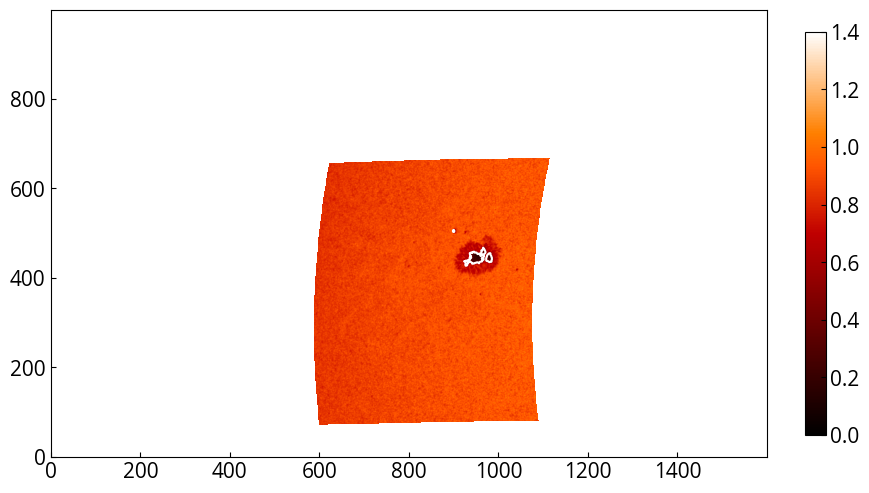

In [109]:
im_no = 60

start_y=1800
end_y=2800

start_x=0
end_x=1600

tmp_ic= hmi_ic_arr[start_y:end_y,start_x:end_x,im_no]
limb_fac = np.mean(tmp_ic[~np.isnan(tmp_ic)])
test_thresh=limb_fac*0.55

print(im_no, test_thresh)

plt.figure(figsize=(10,10))
im=plt.imshow(hmi_ic_arr[start_y:end_y,start_x:end_x,im_no],origin="lower",cmap='gist_heat',vmin=0,vmax=1.4)
plt.colorbar(im,fraction=0.026)
CS=plt.contour(hmi_ic_arr[start_y:end_y,start_x:end_x,im_no],levels=[test_thresh],colors='white')
plt.show()

## Unsigned flux, signed flux, mu corrected unsigned flux

In [12]:
tmp_ichrt=[]
tmp_ichmi=[]

tmp_sichrt=[]
tmp_sichmi=[]

hrt_mus=[]
hmi_mus=[]

tmp_ichrtmu=[]
tmp_ichmimu=[]

for i in range(hrt_arr.shape[-1]):
    tmp = hmi_ic_arr[:,:,i]
    fac = np.mean(tmp[~np.isnan(tmp)])
    hmi_umbra=np.where(tmp/fac<=0.55)
    
    hrt_noise=np.where(np.abs(hrt_arr[:,:,i][hmi_umbra])>50)
    hmi_noise=np.where(np.abs(hmi_arr[:,:,i][hmi_umbra])>50)
    
    tmp_ichrt.append(np.sum(np.abs(hrt_arr[:,:,i][hmi_umbra][hrt_noise])))
    tmp_ichmi.append(np.sum(np.abs(hmi_arr[:,:,i][hmi_umbra][hmi_noise])))
    
    tmp_sichrt.append(np.sum(hrt_arr[:,:,i][hmi_umbra][hrt_noise]))
    tmp_sichmi.append(np.sum(hmi_arr[:,:,i][hmi_umbra][hmi_noise]))
    
    hrt_mu=hrt_mu_arr[:,:,i][hmi_umbra][hrt_noise]
    hmi_mu=hmi_mu_arr[:,:,i][hmi_umbra][hmi_noise]
    
    hrt_mus.append(np.mean(hrt_mu))
    hmi_mus.append(np.mean(hmi_mu))
    
    tmp_ichrtmu.append(np.sum(np.abs(hrt_arr[:,:,i][hmi_umbra][hrt_noise]/hrt_mu)))
    tmp_ichmimu.append(np.sum(np.abs(hmi_arr[:,:,i][hmi_umbra][hmi_noise]/hmi_mu)))

tmp_ichrt=np.array(tmp_ichrt)
tmp_ichmi=np.array(tmp_ichmi)

tmp_sichrt=np.array(tmp_sichrt)
tmp_sichmi=np.array(tmp_sichmi)

hrt_mus=np.array(hrt_mus)
hmi_mus=np.array(hmi_mus)
tmp_ichrtmu=np.array(tmp_ichrtmu)
tmp_ichmimu=np.array(tmp_ichmimu)

In [13]:
with open('/data/slam/sinjan/arlongterm_pickles/hrt_mu_avg_sunspot_20231012_20231017.pickle','wb') as f:
    cPickle.dump(hrt_mus,f)

with open('/data/slam/sinjan/arlongterm_pickles/hmi_mu_avg_sunspot_20231012_20231017.pickle','wb') as f:
    cPickle.dump(hmi_mus,f)

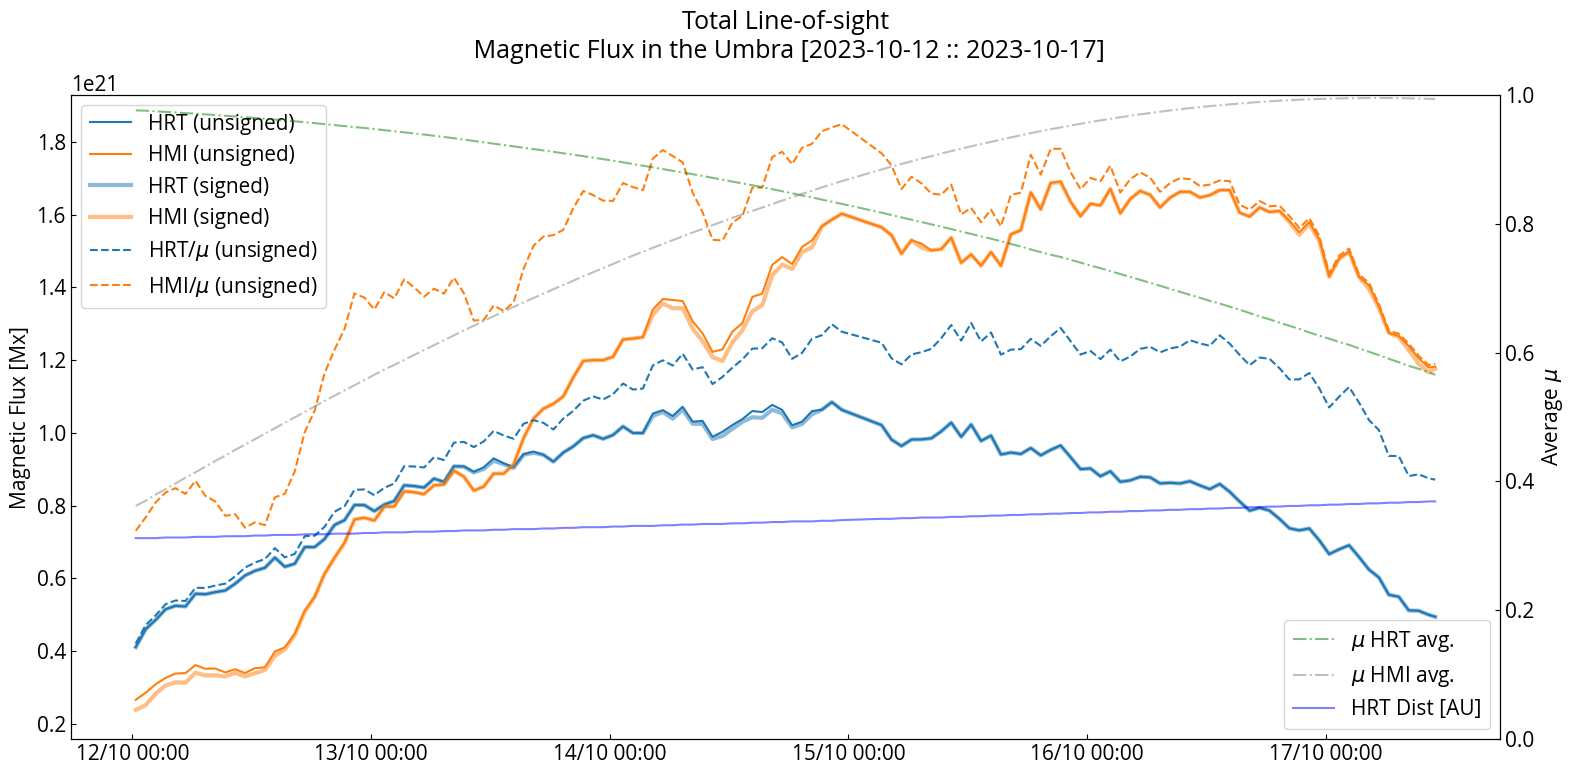

In [32]:
plt.figure(figsize=(16,8))
plt.plot(times,tmp_ichrt*hmisize**2,label=r'HRT (unsigned)',color='#1f77b4')
plt.plot(times,tmp_ichmi*hmisize**2,label=r'HMI (unsigned)',color='#ff7f0e')

plt.plot(times,tmp_sichrt*hmisize**2,label=r'HRT (signed)',color='#1f77b4',linewidth=3,alpha=0.5)
plt.plot(times,tmp_sichmi*hmisize**2,label=r'HMI (signed)',color='#ff7f0e',linewidth=3,alpha=0.5)

plt.plot(times,tmp_ichrtmu*hmisize**2,label=r'HRT/$\mu$ (unsigned)',color='#1f77b4',linestyle='--')
plt.plot(times,tmp_ichmimu*hmisize**2,label=r'HMI/$\mu$ (unsigned)',color='#ff7f0e',linestyle='--')

plt.ylabel('Magnetic Flux [Mx]')
plt.legend(loc='upper left')
ax=plt.gca()
ax2=ax.twinx()

ax2.plot(times,hrt_mus,label='$\mu$ HRT avg.', color='green',alpha=0.5,linestyle='-.')
ax2.plot(times,hmi_mus,label='$\mu$ HMI avg.', color='grey',alpha=0.5,linestyle='-.')
#ax2.plot(times,hrt_dist,label='HRT Dist [AU]',color='blue',alpha=0.5)
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.title(f'Total Line-of-sight\n Magnetic Flux in the Umbra [{times[0].date()} :: {times[-1].date()}]\n')
plt.ylabel(r'Average $\mu$')
plt.xlabel('Time [UTC]')
ax=plt.gca()
ax.xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

In [127]:
np.mean(tmp_ichrtmu/tmp_ichmimu)

np.float64(0.712180200064174)

In [128]:
np.std(tmp_ichrtmu/tmp_ichmimu)

np.float64(0.05102428527198529)

In [27]:
with open('/data/slam/sinjan/arlongterm_pickles/hrt_mu_avg_sunspot_20231012_20231017.pickle','rb') as f:
    hrt_mus=cPickle.load(f)

with open('/data/slam/sinjan/arlongterm_pickles/hmi_mu_avg_sunspot_20231012_20231017.pickle','rb') as f:
    hmi_mus=cPickle.load(f)

In [28]:
hmi_vr_vrot = [i-1.997*np.sqrt(1-mu**2) for i,mu in zip(hmi_vr,hmi_mus)] #- if sun is moving towards HMI, the sign disappears from the sqrt, so be CAREFUL

Text(0.5, 0, 'Time [UTC]')

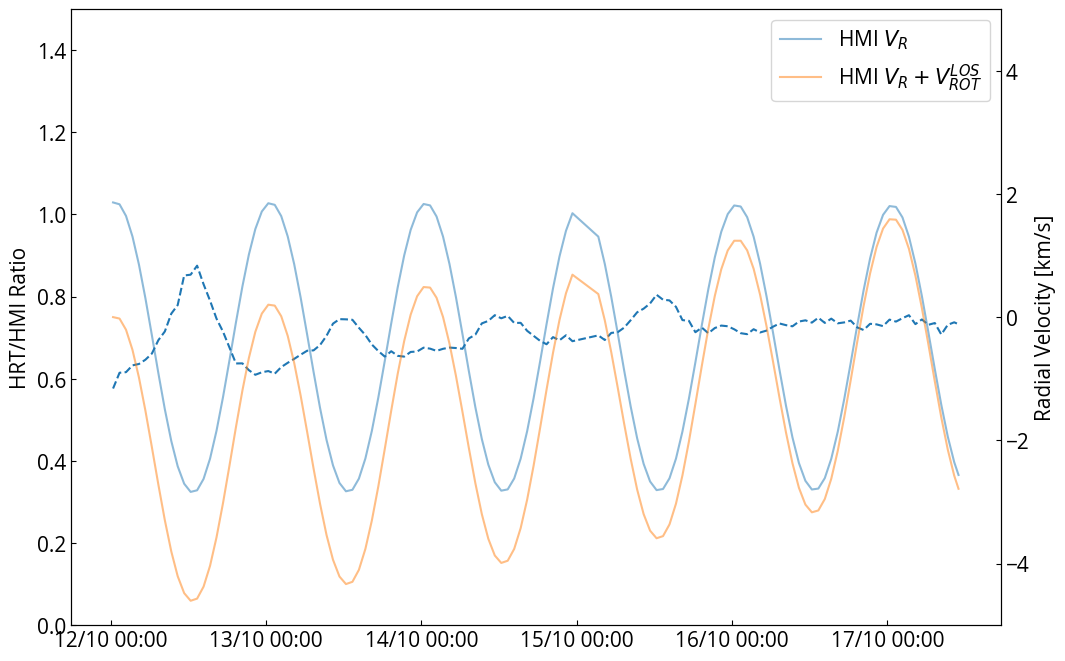

In [30]:
plt.figure(figsize=(12,8))
plt.plot(times,tmp_ichrtmu/tmp_ichmimu,label=r'$\mu$-corrected unsigned flux',linestyle='--')
#plt.plot(times,tmp_ichrt/tmp_ichmi,label=r'unsigned flux',linestyle='--')
#plt.plot(times,tmp_sichrt/tmp_sichmi,label=r'signed flux',linestyle='--')
plt.ylabel('HRT/HMI Ratio')
plt.ylim(0,1.5)
ax=plt.gca()
ax2=ax.twinx()
ax2.plot(times,hmi_vr,label=r'HMI $V_{R}$',alpha=0.5)
ax2.plot(times,hmi_vr_vrot,label=r'HMI $V_{R} + V_{ROT}^{LOS}$',alpha=0.5)
ax2.set_ylabel(r'Radial Velocity [km/s]')
ax2.set_ylim(-5,5)
ax.xaxis.set_major_formatter(myFmt)
plt.legend()
plt.xlabel('Time [UTC]')

# Roll HRT arrays to the left from 16th onwards,and more on the 17th 

In [19]:
tmp_ichrt_roll=[]
tmp_ichmi_roll=[]

tmp_sichrt_roll=[]
tmp_sichmi_roll=[]

hrt_mus_roll=[]
hmi_mus_roll=[]

tmp_ichrtmu_roll=[]
tmp_ichmimu_roll=[]

for i in range(hrt_arr.shape[-1]):
    tmp = hmi_ic_arr[:,:,i]
    fac = np.mean(tmp[~np.isnan(tmp)])
    hmi_umbra=np.where(tmp/fac<=0.55)

    tmp_hrt = hrt_arr[:,:,i]
    tmp_hrt_mu = hrt_mu_arr[:,:,i]
    if i > 72:
        tmp_hrt = np.roll(hrt_arr[:,:,i],-1,axis=1)
        tmp_hrt_mu = np.roll(hrt_mu_arr[:,:,i],-1,axis=1)
    elif i > 92:
        tmp_hrt = np.roll(hrt_arr[:,:,i],-2,axis=1)
        tmp_hrt_mu = np.roll(hrt_mu_arr[:,:,i],-2,axis=1)
    elif i > 116:
        tmp_hrt=np.roll(hrt_arr[:,:,i],-3,axis=1)
        tmp_hrt_mu = np.roll(hrt_mu_arr[:,:,i],-3,axis=1)
    
    hrt_noise=np.where(np.abs(tmp_hrt[hmi_umbra])>50)
    hmi_noise=np.where(np.abs(hmi_arr[:,:,i][hmi_umbra])>50)
    
    tmp_ichrt_roll.append(np.sum(np.abs(tmp_hrt[hmi_umbra][hrt_noise])))
    tmp_ichmi_roll.append(np.sum(np.abs(hmi_arr[:,:,i][hmi_umbra][hmi_noise])))
    
    tmp_sichrt_roll.append(np.sum(tmp_hrt[hmi_umbra][hrt_noise]))
    tmp_sichmi_roll.append(np.sum(hmi_arr[:,:,i][hmi_umbra][hmi_noise]))
    
    hrt_mu=tmp_hrt_mu[hmi_umbra][hrt_noise]
    hmi_mu=hmi_mu_arr[:,:,i][hmi_umbra][hmi_noise]
    
    hrt_mus_roll.append(np.mean(hrt_mu))
    hmi_mus_roll.append(np.mean(hmi_mu))
    
    tmp_ichrtmu_roll.append(np.sum(np.abs(tmp_hrt[hmi_umbra][hrt_noise]/hrt_mu)))
    tmp_ichmimu_roll.append(np.sum(np.abs(hmi_arr[:,:,i][hmi_umbra][hmi_noise]/hmi_mu)))

tmp_ichrt_roll=np.array(tmp_ichrt_roll)
tmp_ichmi_roll=np.array(tmp_ichmi_roll)

tmp_sichrt_roll=np.array(tmp_sichrt_roll)
tmp_sichmi_roll=np.array(tmp_sichmi_roll)

hrt_mus_roll=np.array(hrt_mus_roll)
hmi_mus_roll=np.array(hmi_mus_roll)
tmp_ichrtmu_roll=np.array(tmp_ichrtmu_roll)
tmp_ichmimu_roll=np.array(tmp_ichmimu_roll)

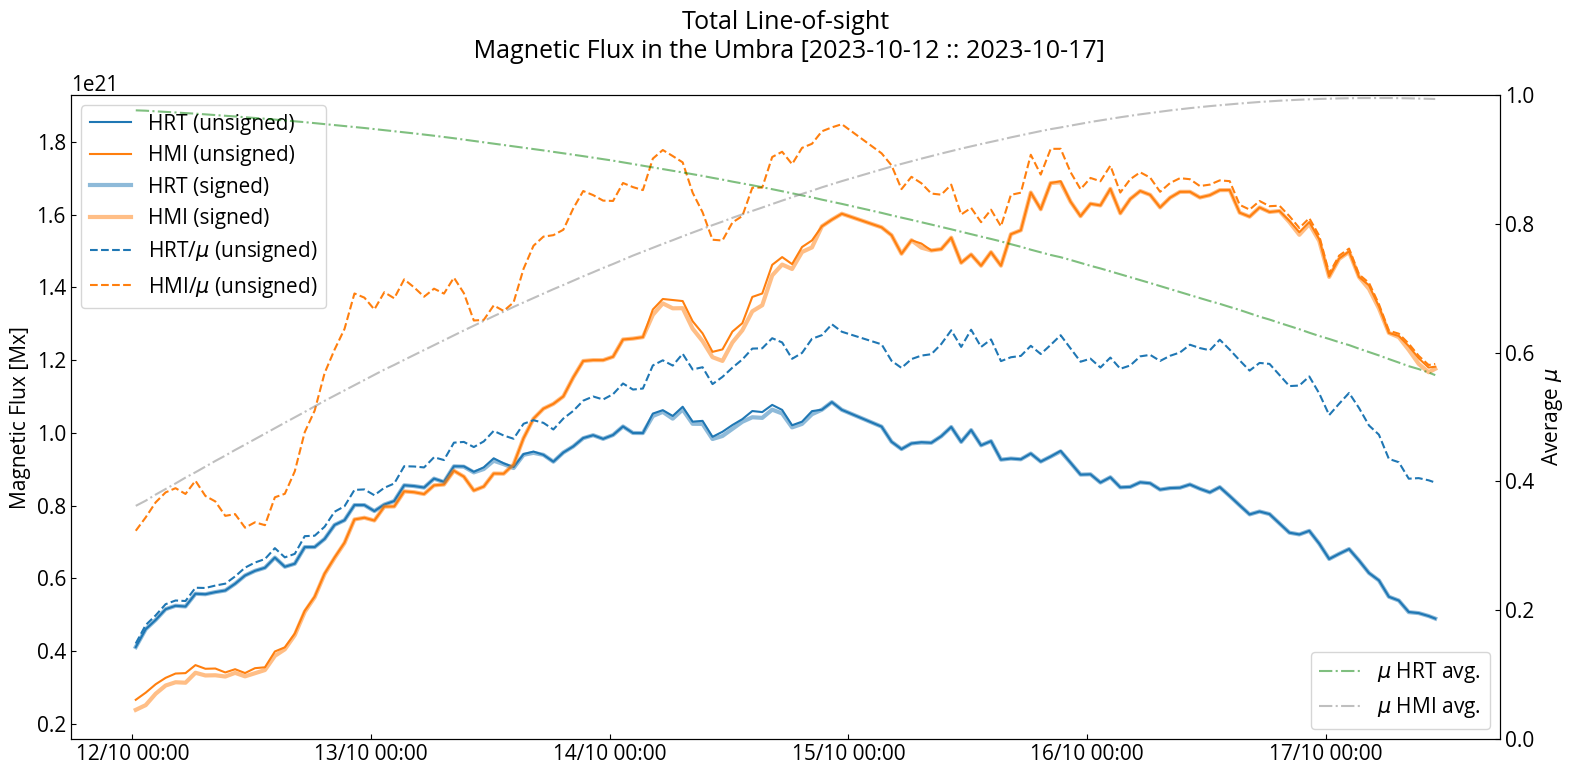

In [40]:
plt.figure(figsize=(16,8))
plt.plot(times,tmp_ichrt_roll*hmisize**2,label=r'HRT (unsigned)',color='#1f77b4')
plt.plot(times,tmp_ichmi_roll*hmisize**2,label=r'HMI (unsigned)',color='#ff7f0e')

plt.plot(times,tmp_sichrt_roll*hmisize**2,label=r'HRT (signed)',color='#1f77b4',linewidth=3,alpha=0.5)
plt.plot(times,tmp_sichmi_roll*hmisize**2,label=r'HMI (signed)',color='#ff7f0e',linewidth=3,alpha=0.5)

plt.plot(times,tmp_ichrtmu_roll*hmisize**2,label=r'HRT/$\mu$ (unsigned)',color='#1f77b4',linestyle='--')
plt.plot(times,tmp_ichmimu_roll*hmisize**2,label=r'HMI/$\mu$ (unsigned)',color='#ff7f0e',linestyle='--')

plt.ylabel('Magnetic Flux [Mx]')
plt.legend(loc='upper left')
ax=plt.gca()
ax2=ax.twinx()

ax2.plot(times,hrt_mus_roll,label='$\mu$ HRT avg.', color='green',alpha=0.5,linestyle='-.')
ax2.plot(times,hmi_mus_roll,label='$\mu$ HMI avg.', color='grey',alpha=0.5,linestyle='-.')
#ax2.plot(times,hrt_dist,label='HRT Dist [AU]',color='blue',alpha=0.5)
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.title(f'Total Line-of-sight\n Magnetic Flux in the Umbra [{times[0].date()} :: {times[-1].date()}]\n')
plt.ylabel(r'Average $\mu$')
plt.xlabel('Time [UTC]')
ax=plt.gca()
ax.xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Time [UTC]')

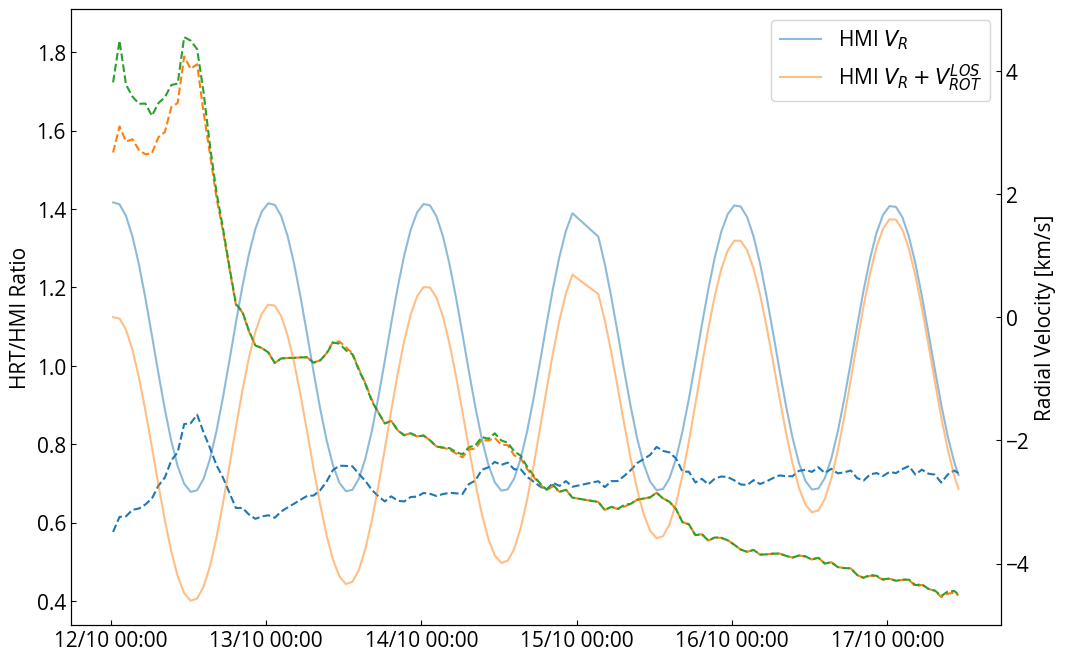

In [31]:
plt.figure(figsize=(12,8))
plt.plot(times,tmp_ichrtmu_roll/tmp_ichmimu_roll,label=r'$\mu$-corrected unsigned flux',linestyle='--')
plt.plot(times,tmp_ichrt_roll/tmp_ichmi_roll,label=r'unsigned flux',linestyle='--')
plt.plot(times,tmp_sichrt_roll/tmp_sichmi_roll,label=r'signed flux',linestyle='--')
plt.ylabel('HRT/HMI Ratio')
#plt.ylim(0,1.5)
ax=plt.gca()
ax2=ax.twinx()
ax2.plot(times,hmi_vr,label=r'HMI $V_{R}$',alpha=0.5)
ax2.plot(times,hmi_vr_vrot,label=r'HMI $V_{R} + V_{ROT}^{LOS}$',alpha=0.5)
ax2.set_ylabel(r'Radial Velocity [km/s]')
ax2.set_ylim(-5,5)
ax.xaxis.set_major_formatter(myFmt)
plt.legend()
plt.xlabel('Time [UTC]')

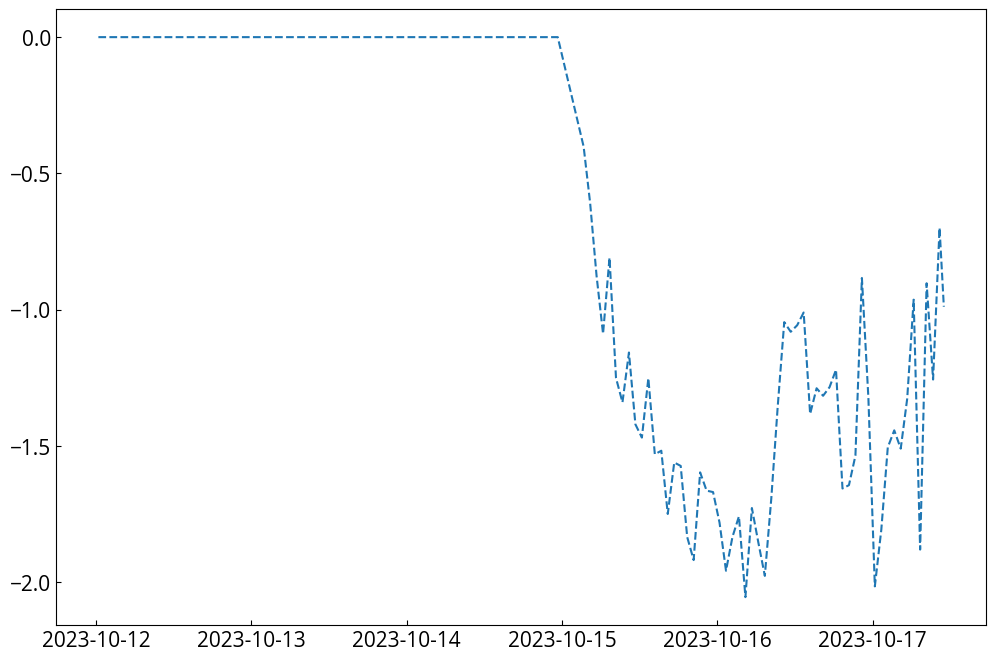

In [49]:
plt.figure(figsize=(12,8))
plt.plot(times,(tmp_ichrt_roll-tmp_ichrt)/(tmp_ichrt)*100,label=r'Roll - No roll',linestyle='--')